# WordJudge: Will your text go to AI jail?

In this notebook we will demostrate the workflow that we have followed during the development of WordJudge.

A detail explanation of the worlflow can be found in the [README.md](https://github.com/MLE2425/word-judge/blob/main/README.md).

We have used custom functions and configurations defined in `data.py`,  `nlp.py` and `cfg.py`, in order to process the data and train the model, while keeping this notebook as clean and simple as possible.

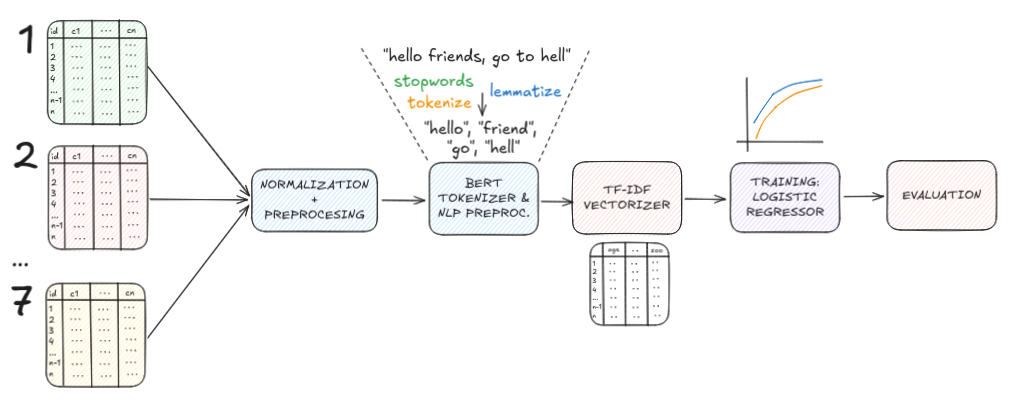

In [6]:
from IPython.display import Image

Image(filename="./img/excalidraw-training.png")

## Imports

In [1]:
# Set root path
import sys
import gc

sys.path.append("..")

import os
import logging

import polars as pl
from cfg import CFG
import skops.io as skio

from src.data.data import load_and_merge_sources
from src.data.nlp import tokenize, tokenize_series

from jax import numpy as jnp
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (
    learning_curve,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt


logger: logging.Logger = logging.getLogger(__name__)

/home/antonio/Documentos/Universidad/Master/MLE/word-judge/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Check sources

Before we start, let's check the sources we have available. If any of them are missing, we will have to download them.

In [3]:
for source in [
    "train_prompts.csv",
    "machine-dev.csv",
    "machine-test.csv",
    "machine-train.csv",
    "train_drcat_01.csv",
    "train_drcat_02.csv",
    "train_drcat_03.csv",
    "train_drcat_04.csv",
    "train_essays.csv",
    "argugpt.csv",
    "essay_forum_real.csv",
    "test",
    "drcat_v3.csv",
    "ivypanda.csv",
    "mlm_real.csv",
    "mlm_synthetic.csv",
]:
    if source not in os.listdir(CFG.data_dir):
        raise FileNotFoundError(f"{source} not found in {CFG.data_dir}")

## Merge sources

We use a previusly defined function to merge the sources into a single dataframe.

The configuration for this can be found in src/cfg.py and the function in src/data/data.py

After merging we select only the unique values.

In [4]:
sources: pl.DataFrame = load_and_merge_sources()
sources = sources.unique(subset=["text"])
print(sources["text"].value_counts())
print(sources["generated"].value_counts())

/Users/adrf/Desktop/uni/master/mle/ia-text-detector/src/cfg.py:49: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  "ivypanda.*": lambda x: x.sample(n=50000).with_columns(


shape: (150_406, 2)
┌─────────────────────────────────┬───────┐
│ text                            ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ The successful "Day Without Ca… ┆ 1     │
│ Mindsets in the Classroom: Def… ┆ 1     │
│ Lots of people in the world us… ┆ 1     │
│  The electoral college is a sy… ┆ 1     │
│ here is the essay question:A r… ┆ 1     │
│ …                               ┆ …     │
│ Claim 1: The Face is a natural… ┆ 1     │
│ This is my essay, please give … ┆ 1     │
│ I agree that education is expe… ┆ 1     │
│ HR Critical Thinking: Where Do… ┆ 1     │
│ In my search for a university,… ┆ 1     │
└─────────────────────────────────┴───────┘
shape: (2, 2)
┌───────────┬───────┐
│ generated ┆ count │
│ ---       ┆ ---   │
│ i8        ┆ u32   │
╞═══════════╪═══════╡
│ 0         ┆ 75616 │
│ 1         ┆ 74790 │
└───────────┴───────┘


In [5]:
# Plot distribution of each column
for col in sources.columns:
    print(sources[col].value_counts())

shape: (150_406, 2)
┌─────────────────────────────────┬───────┐
│ text                            ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ A World Without Ice: Effects o… ┆ 1     │
│ Quality & Rate Factors in Mana… ┆ 1     │
│ Describe the world you come fr… ┆ 1     │
│ The article "Driverless Cars a… ┆ 1     │
│ Very few people have had an ad… ┆ 1     │
│ …                               ┆ …     │
│ "I personally believe that vid… ┆ 1     │
│ The Face on Mars, located in t… ┆ 1     │
│ Have you ever wondered about t… ┆ 1     │
│ Title: Unveiling the Mysteries… ┆ 1     │
│ Literature Comparison: This Is… ┆ 1     │
└─────────────────────────────────┴───────┘
shape: (2, 2)
┌───────────┬───────┐
│ generated ┆ count │
│ ---       ┆ ---   │
│ i8        ┆ u32   │
╞═══════════╪═══════╡
│ 0         ┆ 75616 │
│ 1         ┆ 74790 │
└───────────┴───────┘
shape: (7, 2)
┌──────────────────────┬────

## Tokenize

To avoid memory issues, we will split the data into chunks and tokenize them separately, then merge them back together.

In [6]:
# Split dataset in 26k rows each, tokenize and save separately to save memory using a sliding window

# Split dataset in 26k rows each
n = 26000
for i, pos in enumerate(range(0, len(sources), n)):
    split = sources[pos : pos + n]
    tokenized = split.with_columns(
        pl.col("text").map_batches(function=tokenize_series).alias("tokens"),
    )
    tokenized.write_csv(f"{CFG.project_dir}/output/tokenized_sources_split-{i}.csv")
    del split, tokenized
    gc.collect()

del sources
gc.collect()

Tokenizing: 100%|██████████| 20406/20406 [00:20<00:00, 972.76it/s] 


0

In [7]:
tokenized_sources = []
for file in os.listdir(f"{CFG.project_dir}/output"):
    if "tokenized_sources_split" in file:
        tokenized_sources.append(pl.read_csv(f"{CFG.project_dir}/output/{file}"))

tokenized_sources = pl.concat(tokenized_sources, how="vertical", parallel=True)
tokenized_sources.write_csv(f"{CFG.project_dir}/output/tokenized_sources.csv")

Now that we have the data tokenized, we need to perform ifidf on it before we can use it for training

In [8]:
# Each "tokens" columns appears as
# "[['asdasd', 'asdasd],['asdasdasd','adsasdasd']]"
# We need them to be a space separated list of words


def flatten_series(s: pl.Series) -> pl.Series:
    return s.map_elements(
        lambda x: x.replace("'", "")
        .replace("[", "")
        .replace("]", "")
        .replace(",", "")
        .replace("CLS ", "")
        .replace("SEP", "")
        .replace("  ", " ")
    )


tokenized = pl.read_csv(f"{CFG.project_dir}/output/tokenized_sources.csv")
tokenized = tokenized.with_columns(
    pl.col("tokens").map_batches(function=flatten_series).alias("tokens"),
)

/var/folders/lr/h243hf4s6wl2jnyg3s9h3jlm0000gn/T/ipykernel_13299/2102557886.py:7: PolarsInefficientMapWarning: 
Series.map_elements is significantly slower than the native series API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - s.map_elements(lambda x: ...)
with this one instead:
  + s.str.replace_all("'",'',literal=True).str.replace_all('[','',literal=True).str.replace_all(']','',literal=True).str.replace_all(',','',literal=True).str.replace_all('CLS ','',literal=True).str.replace_all('SEP','',literal=True).str.replace_all('  ',' ',literal=True)

  return s.map_elements(
/var/folders/lr/h243hf4s6wl2jnyg3s9h3jlm0000gn/T/ipykernel_13299/2102557886.py:7: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  return s.map_elements(


In [9]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(tokenized["tokens"].to_numpy())
print(
    "Términos: ",
    vectorizer.get_feature_names_out(),
    " Número de términos: ",
    len(vectorizer.get_feature_names_out()),
)
print("Idf: ", vectorizer.idf_, "(Longitud): ", len(vectorizer.idf_))

Términos:  ['00' '000' '001' ... 'ан' 'ия' 'ка']  Número de términos:  22507
Idf:  [ 6.49138075  4.74724278  9.7430464  ... 12.22795305 12.22795305
 12.22795305] (Longitud):  22507


In [10]:
# Save the model for future use
skio.dump(vectorizer, f"{CFG.project_dir}/output/tfidf_vectorizer.skops")

# Training

We divide the data into training and testing sets in order to train and evaluate the model.

In [14]:
x_train, x_test, y_train, y_test = train_test_split(
    X, tokenized["generated"].to_numpy(), test_size=0.2, random_state=42
)

Now with Linear Regression

In [15]:
# Train a model
model = LogisticRegression()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring="accuracy")
model = model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [17]:
skio.dump(model, f"{CFG.project_dir}/output/logistic_regressor.skops")

### Evaluation

We will evaluate the models using the RMSE metric, R2 and MAE

In [18]:
# Print results
print("CV Metrics:")
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())
print("-----------------------------------")
print("Classification Metrics:")
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))
print("-----------------------------------")
print("Confusion Matrix")
print(metrics.confusion_matrix(y_test, y_pred))
print("-----------------------------------")
print("Regression Metrics")
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", metrics.mean_squared_error(y_test, y_pred))
print("R2 Score:", metrics.r2_score(y_test, y_pred))
print("-----------------------------------")

CV Metrics:
Cross-validation scores: [0.98981924 0.99023478 0.98998546 0.99073343 0.98944481]
Mean accuracy: 0.9900435441081556
Standard deviation: 0.00043004165369511126
-----------------------------------
Classification Metrics:
Accuracy: 0.99035968353168
Precision: 0.9948993288590604
Recall: 0.9857693842266259
F1 Score: 0.9903133141826441
-----------------------------------
Confusion Matrix
[[14968    76]
 [  214 14824]]
-----------------------------------
Regression Metrics
Mean Absolute Error: 0.009640316468319926
Mean Squared Error: 0.009640316468319926
R2 Score: 0.9614387325926672
-----------------------------------


In [20]:
metrics.roc_auc_score(y_test, y_pred)

0.9903587681569185

### Training sizes

We will train the models with different sizes of the dataset to see how the performance changes to observe if more data would result in better models given the learning curve of the model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

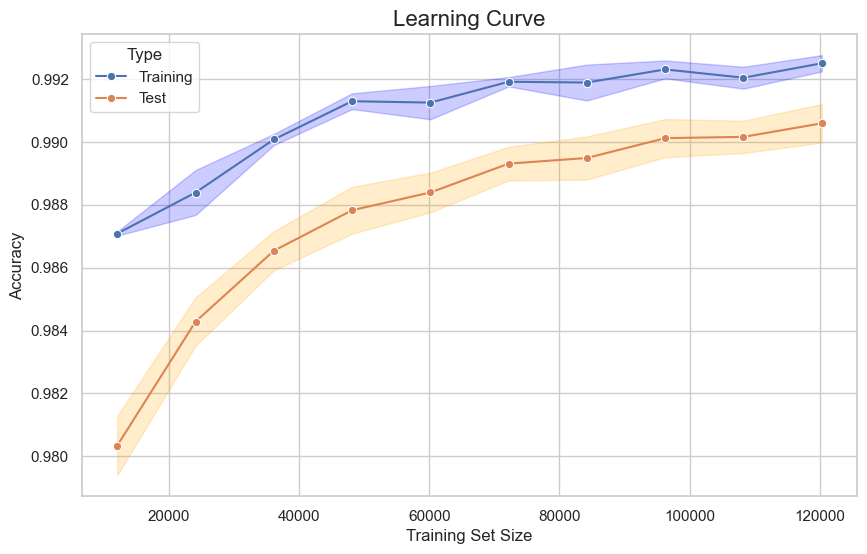

In [19]:
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    # Compute learning curves
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, scoring="accuracy"
    )

    # Use JAX for computation
    train_mean = jnp.mean(train_scores, axis=1)
    train_std = jnp.std(train_scores, axis=1)
    test_mean = jnp.mean(test_scores, axis=1)
    test_std = jnp.std(test_scores, axis=1)

    # Convert back to NumPy for compatibility with Polars
    train_mean = np.array(train_mean)
    train_std = np.array(train_std)
    test_mean = np.array(test_mean)
    test_std = np.array(test_std)

    # Prepare data using Polars
    data = pl.DataFrame(
        {
            "Train Size": np.concatenate([train_sizes, train_sizes]),
            "Accuracy": np.concatenate([train_mean, test_mean]),
            "Type": ["Training"] * len(train_sizes) + ["Test"] * len(train_sizes),
        }
    )

    # Plot using Seaborn
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=data.to_pandas(), x="Train Size", y="Accuracy", hue="Type", marker="o"
    )

    # Add error bars
    plt.fill_between(
        train_sizes,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.2,
        color="blue",
    )
    plt.fill_between(
        train_sizes,
        test_mean - test_std,
        test_mean + test_std,
        alpha=0.2,
        color="orange",
    )

    # Customize plot
    plt.title("Learning Curve", fontsize=16)
    plt.xlabel("Training Set Size", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend(title="Type", loc="best")
    plt.grid(True)
    plt.show()


# Define the estimator
estimator = LogisticRegression()

# Plot the learning curve
plot_learning_curve(estimator, X, tokenized["generated"].to_numpy())

## Make predictions on never-seen text

As described in the README, we will use the PERSUADE corpus to validate our model with texts of different sources and nature of our training dataset.

We ensure a 50/50 split between AI generated and human generated text. As well, we will use the same tokenizer and vectorizer that we used for training.

In [49]:
validation_real = pl.read_csv(f"{CFG.data_dir}/mlm_real.csv")
validation_real = validation_real.select(validation_real["essay_text"].alias("text"))
validation_synthetic = pl.read_csv(f"{CFG.data_dir}/mlm_synthetic.csv")
validation_synthetic = validation_synthetic.group_by("essay_id").head(1)
validation_synthetic = validation_synthetic.select(
    validation_synthetic["discourse_text"].alias("text")
)
validation_real = validation_real.with_columns(
    generated=pl.Series([0] * len(validation_real))
)
validation_synthetic = validation_synthetic.with_columns(
    generated=pl.Series([1] * len(validation_synthetic))
)
validation = pl.concat([validation_real, validation_synthetic], parallel=True)
validation["generated"].value_counts()

generated,count
i64,u32
1,35743
0,35762


In [50]:
validation.write_csv(f"{CFG.project_dir}/output/validation.csv")

In [51]:
model = skio.load(f"{CFG.project_dir}/output/logistic_regressor.skops")
vectorizer = skio.load(f"{CFG.project_dir}/output/tfidf_vectorizer.skops")

validation = pl.read_csv(f"{CFG.project_dir}/output/validation.csv")

X_val = vectorizer.transform(validation["text"].to_numpy())
y_val = validation["generated"].to_numpy()

y_pred = model.predict(X_val)

In [52]:
print("-----------------------------------")
print("Classification Metrics:")
print("Accuracy:", metrics.accuracy_score(y_val, y_pred))
print("Precision:", metrics.precision_score(y_val, y_pred))
print("Recall:", metrics.recall_score(y_val, y_pred))
print("F1 Score:", metrics.f1_score(y_val, y_pred))
print("-----------------------------------")
print("Confusion Matrix")
print(metrics.confusion_matrix(y_val, y_pred))
print("-----------------------------------")
print("Regression Metrics")
print("Mean Absolute Error:", metrics.mean_absolute_error(y_val, y_pred))
print("Mean Squared Error:", metrics.mean_squared_error(y_val, y_pred))
print("R2 Score:", metrics.r2_score(y_val, y_pred))
print("-----------------------------------")

-----------------------------------
Classification Metrics:
Accuracy: 0.5565205230403468
Precision: 0.9975320829220138
Recall: 0.1130850795960048
F1 Score: 0.2031410981279055
-----------------------------------
Confusion Matrix
[[35752    10]
 [31701  4042]]
-----------------------------------
Regression Metrics
Mean Absolute Error: 0.4434794769596532
Mean Squared Error: 0.4434794769596532
R2 Score: -0.7739180330857851
-----------------------------------
